GIT import inspired by Biswaroop's F3 notebooks, trying to port over to an existing DGPE sim package. https://www.pi5.uni-stuttgart.de/documents/abgeschlossene-arbeiten/2018-Wenzel-Matthias-Macroscopic-States-of-Dipolar-Quantum-Gases-PhD.pdf

In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from copy import copy, deepcopy
from IPython.display import HTML
from base64 import b64encode

def show_video(filename='output.mp4'):
  mp4 = open(filename,'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML("""
  <video width=400 controls>
        <source src="%s" type="video/mp4">
  </video>
  """ % data_url)

########################################################

from scipy import ndimage
import pandas as pd
from scipy.optimize import curve_fit
import scipy.misc
import scipy.constants as cst
from scipy import signal
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import skimage
from skimage.feature import blob_dog, blob_log, blob_doh
import math
import scipy.misc
from scipy import signal
from skimage.restoration import unwrap_phase
import skimage.filters
import matplotlib.animation as animation
from skimage.filters.rank import median
from random import random
import copy
import pickle
from functools import reduce
import operator
from google.colab import drive



In [2]:

path = "/content"
os.chdir(path)

if os.path.exists('/content/GPE-Solver/gpe/build/'):
  print('Codebase already loaded')
else:
  print('Loading codebase...')
  !git clone https://github.com/Fletcher-Labs/GPE-Solver.git
  %cd GPE-Solver/gpe
  !apt-get update #new
  !apt-get install libfftw3-dev #new
  !apt-get install -qq libglew-dev swig. 
  !ln -sf /usr/local/lib/python3.7/dist-packages/numpy/core/include/numpy /usr/include/numpy
  #!mkdir build
  #!./build.sh
%cd '/content/GPE-Solver/gpe'
!make 
print('Ready.')

Loading codebase...
Cloning into 'GPE-Solver'...
remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 133 (delta 6), reused 0 (delta 0), pack-reused 118
Receiving objects: 100% (133/133), 1.42 MiB | 5.77 MiB/s, done.
Resolving deltas: 100% (57/57), done.
/content/GPE-Solver/gpe
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 https://developer.dow

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
#Makefile compiles, trying to get example working...

Running a simple example

In [11]:
#%cd ../content/GPE-Solver/
%cd ../content/GPE-Solver

/content/GPE-Solver


In [14]:
print('Harmonic trap imaginary time evolution')
print('')
print('Time             Total Energy    Kin. Energy    Pot. Energy    Contact Energy    Dipolar Energy    Virial')

#!python simple.py
!python simple.py | awk '{print $7}' #take a column

Harmonic trap imaginary time evolution

Time             Total Energy    Kin. Energy    Pot. Energy    Contact Energy    Dipolar Energy    Virial
1.196826841
0.294220685
0.088461874
0.028357825
0.010269524
0.004787792
0.003122725
0.002616523
0.002462577
0.002415753
0.002401511
0.002397178
0.002395860
0.002395460
0.002395338
0.002395301
0.002395289
0.002395286
0.002395285
0.002395284
0.002395284


In [51]:
#Data analysis to compare with fig 6.1

t=[0,500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000,6500,7000,7500,8000,8500,9000,9500,10000]
E=[1.898942280,1.816250722,1.811681161,1.811266001,1.811224288,1.811219385,1.811218615,1.811218447,1.811218402,1.811218389,1.811218385,1.811218384,1.811218384,1.811218384,1.811218384,1.811218384,1.811218384,1.811218384,1.811218384,1.811218384,1.811218384]
K=[0.750000000,0.629186640,0.600273898,0.591656794,0.589042495,0.588247365,0.588005458,0.587931865,0.587909478,0.587902667,0.587900596,0.587899966,0.587899774,0.587899716,0.587899698,0.587899692,0.587899691,0.587899690,0.587899690,0.587899690,0.587899690]
U=[0.750000000,0.905068968,0.949261542,0.962756677,0.966872169,0.968124600,0.968505532,0.968621391,0.968656630,0.968667349,0.968670610,0.968671602,0.968671903,0.968671995,0.968672023,0.968672032,0.968672034,0.968672035,0.968672035,0.968672035,0.968672035]
C=[0.398942280,0.281995114,0.262145721,0.256852530,0.255309624,0.254847421,0.254707624,0.254665191,0.254652294,0.254648373,0.254647180,0.254646817,0.254646706,0.254646673,0.254646663,0.254646660,0.254646659,0.254646658,0.254646658,0.254646658,0.254646658]
D=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
V=[1.196826841,0.294220685,0.088461874,0.028357825,0.010269524,0.004787792,0.003122725,0.002616523,0.002462577,0.002415753,0.002401511,0.002397178,0.002395860,0.002395460,0.002395338,0.002395301,0.002395289,0.002395286,0.002395285,0.002395284,0.002395284]




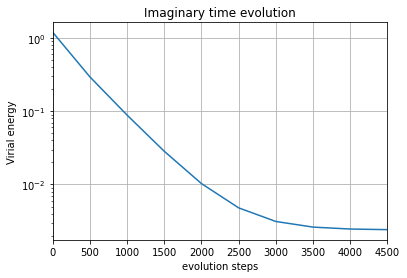

In [65]:
plt.plot(np.array(t),V)
plt.yscale("log")
plt.grid()
plt.xlabel('evolution steps')
plt.ylabel('Virial energy')
plt.title('Imaginary time evolution')
plt.xlim([0,4500])
plt.show();

In [ ]:
# This also spits out density cuts in a mat file!

In [12]:
# Running a lattice sim
print('2-site lattice imaginary time evolution')
print('')
print('Time             Total Energy    Kin. Energy    Pot. Energy    Contact Energy    Dipolar Energy    Virial')

!python lattice.py


Harmonic trap imaginary time evolution

Time             Total Energy    Kin. Energy    Pot. Energy    Contact Energy    Dipolar Energy    Virial
00000000	 11.533624561	 18.582988145	-39.645975092	 23.788297883	 8.808313625	 214.247760998
00000500	-21.181317605	 9.677101161	-38.783844448	 9.854226313	-1.928800631	 120.698168263
00001000	-21.181317891	 9.676872982	-38.783352930	 9.853987301	-1.928825245	 120.695937995
00001500	-21.181317891	 9.676872803	-38.783352576	 9.853987124	-1.928825243	 120.695936402
00002000	-21.181317891	 9.676872803	-38.783352576	 9.853987124	-1.928825243	 120.695936401
00002500	-21.181317891	 9.676872803	-38.783352576	 9.853987124	-1.928825243	 120.695936401
00003000	-21.181317891	 9.676872803	-38.783352576	 9.853987124	-1.928825243	 120.695936401
00003500	-21.181317891	 9.676872803	-38.783352576	 9.853987124	-1.928825243	 120.695936401
00004000	-21.181317891	 9.676872803	-38.783352576	 9.853987124	-1.928825243	 120.695936401
00004500	-21.181317891	 9.6768728

Example contact interaction spectral method. https://github.com/brownjm/gpe

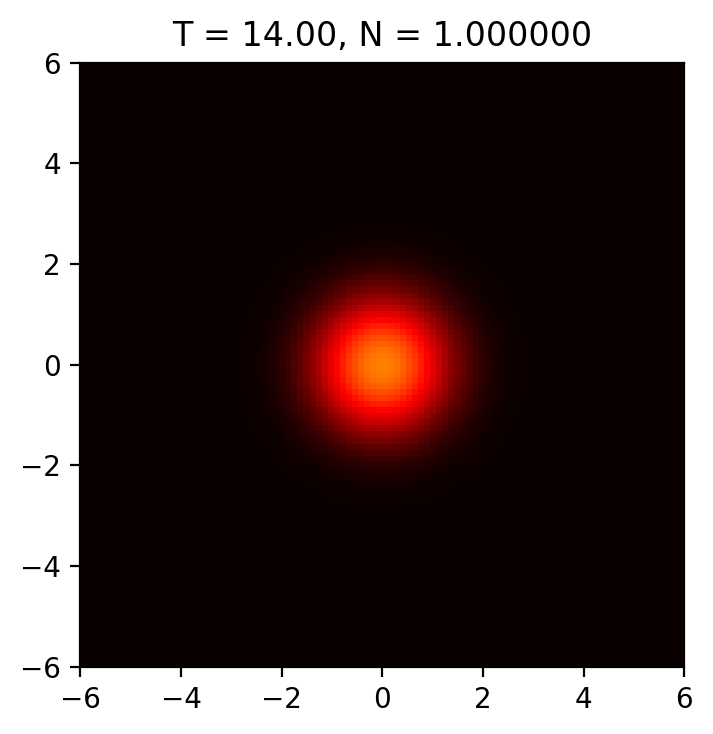

In [51]:
"""Spectral method for evolving GPE for BEC's"""

from numpy import exp, pi, arange, meshgrid, sqrt, linspace
from numpy.fft import fft2, ifft2, fftshift
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation

matplotlib.rcParams['figure.dpi'] = 200

from matplotlib import rc
rc('animation', html='jshtml')

class QHO:
    """Quantum harmonic oscillator wavefunctions"""
    def __init__(self, n, xshift=0, yshift=0):
        self.n = n
        self.xshift = xshift
        self.yshift = yshift
        self.E = n + 0.5
        self.coef = 1 / sqrt(2**n * factorial(n)) * (1 / pi)**(1/4)
        self.hermite = hermite(n)

    def __call__(self, x, y, t):
        xs = x - self.xshift
        ys = y - self.yshift
        return self.coef * exp(-(xs**2 + ys**2) / 2 - 1j*self.E*t) * self.hermite(x) * self.hermite(y)


class Simulation:
    """Simulation to step wavefunction forward in time from the given parameters
xmax : maximum extent of boundary
N    : number of spatial points
init : initial wavefunction
nonlinearity : factor in front of |psi^2| term
"""
    def __init__(self, parameters):
        self.parameters = parameters

        # set up spatial dimensions
        xmax = parameters['xmax']
        self.xmax = xmax
        N = parameters['N']
        v = linspace(-xmax, xmax, N)
        self.dx = v[1] - v[0]
        self.x, self.y = meshgrid(v, v)

        # spectral space
        kmax = 2*pi / self.dx
        dk = kmax / N
        self.k = fftshift((arange(N)-N/2) * dk)
        kx, ky = meshgrid(self.k, self.k)

        # time
        self.steps = 0
        self.time = 0
        self.dt = self.dx**2 / 4

        # wavefunction
        init_func = parameters['initial']
        self.wf = init_func(self.x, self.y, 0)
        self.wf /= sqrt(self.norm().sum() * self.dx**2) # normalize

        # Hamiltonian operators
        self.loss = 1 - 1j*parameters['loss']
        self.T = exp(-1j * self.loss * (kx**2 + ky**2) * self.dt / 2)
        self.V = exp(-1j * self.loss * (self.x**2 + self.y**2) * self.dt / 2)
        self.eta = parameters['nonlinearity']


    def evolve(self, time):
        """Evolve the wavefunction to the given time in the future"""
        steps = int(time / self.dt)
        if steps == 0:
            steps = 1 # guarantee at least 1 step

        for _ in range(steps):
            #self.linear_step()
            self.nonlinear_step()
            if self.loss:
                N = self.norm().sum()*self.dx**2
                self.wf /= N

        self.update_time(steps)

        
    def linear_step(self):
        """Make one linear step dt forward in time"""
        # kinetic
        self.wf[:] = fft2(ifft2(self.wf) * self.T)

        # potential
        self.wf *= self.V


    def nonlinear_step(self):
        """Make one nonlinear step dt forward in time"""
        # linear step
        self.linear_step()

        # nonlinear
        self.wf *= exp(-1j * self.loss * self.eta * abs(self.wf)**2 * self.dt)


    def update_time(self, steps):
        """Increment time by steps taken"""
        self.steps += steps
        self.time = self.steps * self.dt

    def norm(self):
        return abs(self.wf)**2


    def show(self):
        """Show the current norm of the wavefunction"""
        fig, ax = plt.subplots()
        ax.imshow(self.norm(), cmap=plt.cm.hot)
        plt.show()



def animate(simulation, time, interval=100):
    """Display an animation of the simulation"""
    fig, ax = plt.subplots()
    L = simulation.xmax
    norm = ax.imshow(simulation.norm(), extent=(-L, L, -L, L), cmap=plt.cm.hot)

    def update(i):
        simulation.evolve(time / interval)
        N = simulation.norm()
        norm.set_data(N)
        ax.set_title('T = {:3.2f}, N = {:1.6f}'.format(simulation.time, N.sum()*simulation.dx**2))

    anim = animation.FuncAnimation(fig, update, interval=10)
    plt.show()


    

params = {'N': 100,
              'xmax': 5,
              'nonlinearity': 4,
              'initial': QHO(n=0, xshift=0.0), # GaussianWavepacket(1, 5, -4),
              'loss': 0.0,
              }

sim = Simulation(params)
animate(sim,2800)

In [53]:
sim.evolve(1)